### Resources
1. [Vector Quantized Variational AutoEncoder](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Vector_Quantized_Variational_AutoEncoders.ipynb)
2. [Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937)
3. [Estimating or propagating gradients through stochastic neurons for conditional computation](https://arxiv.org/pdf/1308.3432)


### What is a Vector Quantized Variational Autoencoder?
A Vector Quantized Variational Autoencoder (VQVAR) maps data to a discrete set of vectors. So you have an Encoder Neural Network that takes an image and compresses it down to some Latent Vector $Z$. We then compare continuous $Z$ to all our available discrete codevectors $e$ inside our codebook, and pick the codevector that is closest to our continous vector. The discrete vector is then passed to our decoder and the original image is reconstructed. We have a total of $K$ codevectors. 

<p align="center">
  <img src="https://substack-post-media.s3.amazonaws.com/public/images/0e37c4cc-f94a-49b0-8b5b-ca87c231ca96_1600x681.png" alt="alt" width="700">
</p>


We will create a module that will take a tensor, apply an "encoder" linear layer, quantize it to some embeddings, and then apply a "decoder" linear layer for our output.

Decoder Gradient: tensor([[4.]])
Decoder Gradient: tensor([ 0.0000,  0.0000, -0.4786,  0.0000])
Encoder Gradient: None


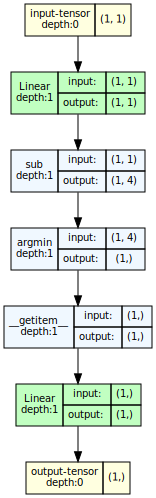

In [2]:
import torch
import torch.nn as nn

from torchview import draw_graph


class Quantize(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Linear(1, 1)
        self.embeddings = nn.Parameter(
            torch.tensor([-10.0, 0.0, 4.0, 3.0]), requires_grad=True
        )
        self.dec = nn.Linear(1, 1)

    def forward(self, x):
        z = self.enc(x)
        closest = torch.argmin((z - self.embeddings), dim=-1)
        e_j = self.embeddings[closest]
        d = self.dec(e_j)
        return d


q = Quantize()
x = torch.ones(1).reshape(-1, 1)
out = q(x)
out.backward()
print("Decoder Gradient:", q.dec.weight.grad)
print("Decoder Gradient:", q.embeddings.grad)
print("Encoder Gradient:", q.enc.weight.grad)

model_graph = draw_graph(q, input_size=(1, 1))
model_graph.visual_graph

We can see above, that the gradient didn't make it back to $z$, which is a problem because then gradients arent making it to our encoder in that case. This happens because `argmin` is non-differentiable so PyTorch cannot compute a useful gradient through this operation.

During backpropagation, we have to find the following derivatives:
- Derivative of the Decoder w.r.t codes $\frac{\partial d}{\partial e_{\text{st}}}$
- Derivative of the codes w.r.t z $\frac{\partial e_{\text{st}}}{\partial z}$ (this is the problematic one)
- Derivative of z w.r.t the Encoder $\frac{\partial z}{\partial w_{\text{enc}}}$

This is the complete chain rule for previous model:
$$
\boxed{
\frac{\partial L}{\partial w_{\text{enc}}}
=
\frac{\partial L}{\partial d}
\cdot
\frac{\partial d}{\partial e_{\text{st}}}
\cdot
\frac{\partial e_{\text{st}}}{\partial z}
\cdot
\frac{\partial z}{\partial w_{\text{enc}}}
}
$$


$\frac{\partial L}{\partial w_{\text{enc}}}$ depends on the loss fomula used (MSE, cross-entropy, etc.) so we'll just call it:

$$
\boxed{
\frac{\partial L}{\partial d} = g_{d}
}
$$

For the next step recall that:

$$
d = w_{\text{dec}} \cdot e_{\text{st}} + b_{\text{dec}}
$$

derivative of $b_{\text{dec}}$ is 0 and derivative of $w_{\text{dec}} \cdot e_{\text{st}}$ is $w_{\text{dec}}$ so:

$$
\boxed{
\frac{\partial d}{\partial e_{\text{st}}} = w_{\text{dec}}
}
$$

$\frac{\partial e_{\text{st}}}{\partial z}$ is where everything stops because:

$$
\boxed{
\frac{\partial \text{argmin}_j |z - e_j|}{\partial z} = 0
}
$$

To build an intuition of why this is not derivable imagine to slightly change `z`, the index `j` (the argmin) stays the same most of the time. In other words the function is piecewise constant. Derivative of a constant is 0 almost everywhere, and undefined at the points where the index changes. So there’s no smooth slope for gradient descent to follow.

The proposed solution from the paper was to use a **straight through estimator** [[3]](https://arxiv.org/pdf/1308.3432), where we will copy the gradients from the input of the decoder to the output of the encoder.

To copy gradients we will do it like this:

```
e_j = z + (e_j - z).detach()
```

Why this works?

$$
e_j^{st} = \underbrace{z}_{\text{has grad}}
         + \underbrace{(e_j - z)^{\text{detach}}}_{\text{no grad}}
$$


$$
\frac{\partial e_{\text{st}}}{\partial z} = \frac{\partial z}{\partial z} + \frac{\partial (e_j - z)^{detach}}{\partial z} = 1 + 0 = 1
$$

Put it all together:

$$
\boxed{
\frac{\partial L}{\partial w_{\text{enc}}}
=
\frac{\partial L}{\partial d}
\cdot
\frac{\partial d}{\partial e_{\text{st}}}
\cdot
\frac{\partial e_{\text{st}}}{\partial z}
\cdot
\frac{\partial z}{\partial w_{\text{enc}}}

= g_{d} \cdot w_{\text{dec}} \cdot 1 \cdot w_{\text{enc}}
}
$$

Encoder Gradient: tensor([[0.6871]])


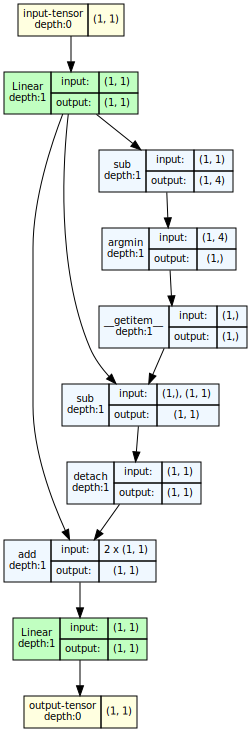

In [3]:
class Quantize(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Linear(1, 1)
        self.embeddings = nn.Parameter(
            torch.tensor([-10.0, 0.0, 4.0, 3.0]), requires_grad=True
        )
        self.dec = nn.Linear(1, 1)

    def forward(self, x):
        z = self.enc(x)
        closest = torch.argmin((z - self.embeddings), dim=-1)
        e_j = self.embeddings[closest]
        e_j = z + (e_j - z).detach()
        d = self.dec(e_j)
        return d


q = Quantize()
x = torch.ones(1).reshape(-1, 1)
out = q(x)
out.backward()
print("Encoder Gradient:", q.enc.weight.grad)

model_graph = draw_graph(q, input_size=(1, 1))
model_graph.visual_graph

There is another optimization trick to know. There are two ways we can compute distances; goal is to compute the mean squared distance between our input $x$ and ALL codevectors $e$, so $(x-e)^2$. In the naive method, we will have to do matrix inflation to get all our shapes to line up, but this is costly. The better way is to rewrite $(x-e)^2$ as $x^2-2xe + e^2$ and just do a couple matrix multiplications to get the same output.

In [4]:
import torch
import time


class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size=1024, latent_dim=2):
        super().__init__()

        self.embedding = nn.Embedding(codebook_size, latent_dim)
        self.embedding.weight.data.uniform_(-1 / codebook_size, 1 / codebook_size)

        self.latent_dim = latent_dim
        self.codebook_size = codebook_size

    def forward(self, x, efficient=True):
        batch_size = x.shape[0]

        ### Bad Implementation That Requires Matrix Expansion ###
        if not efficient:
            # C: Codebook Size, L: Latent Dim

            ### Embedding: [C, L] -> [B, C, L]
            emb = self.embedding.weight.unsqueeze(0).repeat(batch_size, 1, 1)

            ### X: [B, L] -> [B, 1, L]
            x = x.unsqueeze(1)

            ### [B, C]
            distances = torch.sum(((x - emb) ** 2), dim=-1)

        ### Alternative more Efficient Implementation ###
        else:
            ### Distance btwn every Latent and Code: (L-C)**2 = (L**2 - 2LC + C**2 ) ###

            ### L2: [B, L] -> [B, 1]
            L2 = torch.sum(x**2, dim=1, keepdim=True)

            ### C2: [C, L] -> [C]
            C2 = torch.sum(self.embedding.weight**2, dim=1).unsqueeze(0)

            ### CL: [B,L]@[L,C] -> [B, C]
            CL = x @ self.embedding.weight.t()

            ### [B, 1] - 2 * [B, C] + [C] -> [B, C]
            distances = L2 - 2 * CL + C2

        ### Grab Closest Indexes, create matrix of corresponding vectors ###
        ### Closest: [B, 1]
        closest = torch.argmin(distances, dim=-1)

        ### Create Empty Quantized Latents Embedding ###
        # latents_idx: [B, C]
        quantized_latents_idx = torch.zeros(
            batch_size, self.codebook_size, device=x.device
        )

        ### Place a 1 at the Indexes for each sample for the codebook we want ###
        batch_idx = torch.arange(batch_size)
        quantized_latents_idx[batch_idx, closest] = 1

        ### Matrix Multiplication to Grab Indexed Latents from Embeddings ###

        # quantized_latents: [B, C] @ [C, L] -> [B, L]
        quantized_latents = quantized_latents_idx @ self.embedding.weight

        return quantized_latents


def benchmark_vq(
    codebook_size=1024, latent_dim=64, batch_size=256, iters=50, device=None
):
    """Benchmark speed + peak memory of efficient vs inefficient quantization in a single function."""

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n--- Benchmark (device={device}) ---")
    print(f"Batch={batch_size}, Codebook={codebook_size}, Latent={latent_dim}")

    vq = VectorQuantizer(codebook_size=codebook_size, latent_dim=latent_dim).to(device)
    x = torch.randn(batch_size, latent_dim, device=device)

    # Warmup
    with torch.no_grad():
        vq(x, efficient=False)
        vq(x, efficient=True)

    def measure(fn):
        if device == "cuda":
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        start = time.time()
        with torch.no_grad():
            for _ in range(iters):
                fn()
        end = time.time()

        t = (end - start) / iters
        mem = torch.cuda.max_memory_allocated() if device == "cuda" else None
        return t, mem

    # Inefficient
    t_slow, mem_slow = measure(lambda: vq(x, efficient=False))

    # Efficient
    t_fast, mem_fast = measure(lambda: vq(x, efficient=True))

    # Print results
    def fmt(m):
        return f"{m / (1024**2):.2f} MB" if m is not None else "N/A (CPU)"

    print(f"\nInefficient (repeat expand):")
    print(f"  time   : {t_slow * 1000:.3f} ms/iter")
    print(f"  memory : {fmt(mem_slow)}")

    print(f"\nEfficient (no expand):")
    print(f"  time   : {t_fast * 1000:.3f} ms/iter")
    print(f"  memory : {fmt(mem_fast)}")

    if mem_slow and mem_fast:
        print(f"\nMemory ratio (ineff/eff): {mem_slow / mem_fast:.2f}x")
    print(f"Speedup (ineff/eff): {t_slow / t_fast:.2f}x")


benchmark_vq(codebook_size=1024, latent_dim=64, batch_size=64)
benchmark_vq(codebook_size=1024, latent_dim=64, batch_size=512)
benchmark_vq(codebook_size=4096, latent_dim=64, batch_size=512)


--- Benchmark (device=cuda) ---
Batch=64, Codebook=1024, Latent=64

Inefficient (repeat expand):
  time   : 0.311 ms/iter
  memory : 56.40 MB

Efficient (no expand):
  time   : 0.099 ms/iter
  memory : 9.17 MB

Memory ratio (ineff/eff): 6.15x
Speedup (ineff/eff): 3.16x

--- Benchmark (device=cuda) ---
Batch=512, Codebook=1024, Latent=64

Inefficient (repeat expand):
  time   : 3.741 ms/iter
  memory : 392.50 MB

Efficient (no expand):
  time   : 0.116 ms/iter
  memory : 14.64 MB

Memory ratio (ineff/eff): 26.81x
Speedup (ineff/eff): 32.23x

--- Benchmark (device=cuda) ---
Batch=512, Codebook=4096, Latent=64

Inefficient (repeat expand):
  time   : 14.468 ms/iter
  memory : 1545.25 MB

Efficient (no expand):
  time   : 0.256 ms/iter
  memory : 33.40 MB

Memory ratio (ineff/eff): 46.26x
Speedup (ineff/eff): 56.62x


In an ordinary autoencoder, the mean-squared error (MSE) between the input and its reconstruction is
sufficient to train all components end-to-end.

However, once we introduce a **discrete bottleneck**, as in the VQ-VAE, this assumption breaks.
The encoder output \( z_e(x) \) is no longer fed directly to the decoder. Instead, it is replaced by the
nearest codebook vector:

$$
z_q(x) = e_k, \quad k = \arg\min_j \| z_e(x) - e_j \|^2.
$$

This nearest-neighbor quantization is **not differentiable**. During backpropagation, the gradient of the
reconstruction loss has no path into the codebook entries \( e_k \). The VQ-VAE paper states:

> “Due to the straight-through gradient estimation … the embeddings \( e_i \) receive **no gradients from the
reconstruction loss**.”  

This means that if we used only MSE, the decoder would learn, the encoder would learn (via a special
trick described below), **but the quantizer—the codebook—would learn nothing at all**. The codebook
would remain essentially random, and the model would not converge.

This is the central challenge of discrete latent learning:  
**the reconstruction loss cannot update the discrete codes.**

---


To address this, the VQ-VAE introduces a composite objective consisting of three terms:

$$
\mathcal{L} = 
\underbrace{\log p(x \mid z_q(x))}_{\text{reconstruction}} +
\underbrace{\| \text{sg}[z_e(x)] - e_k \|^2}_{\text{codebook loss}} +
\beta \underbrace{\| z_e(x) - \text{sg}[e_k] \|^2}_{\text{commitment loss}}.
$$

Here, **sg** denotes the stop-gradient operator. Each term is responsible for training a different part of
the model. The paper explains this division of labor:

> “The decoder optimizes the first loss term only, the encoder optimizes the first and the last loss terms,
and the embeddings are optimized by the middle loss term.”  


Let’s break these down.

---

**Reconstruction Loss** — Trains Encoder + Decoder. Even though the decoder receives a discrete latent $\( z_q \)$, the encoder receives gradients through the
**straight-through estimator**, which treats the quantization step as if it were the identity during backprop.

As the paper says:

> “During the backward pass the gradient \( \nabla_z L \) is passed unaltered to the encoder.”  

Thus, the encoder learns how its continuous outputs should move to reduce reconstruction error as if no quantization had taken place.

But critically, **the codebook still receives no gradient from this term**.

---

**Codebook Loss** — Trains the Embedding Vectors

To update the quantizer, the authors add a second loss term:

$$
\| \text{sg}[z_e(x)] - e_k \|^2.
$$

This uses the encoder output as a fixed target (thanks to stop-gradient) and updates only the embedding
vectors. The paper describes this as:

> “One of the simplest dictionary learning algorithms, Vector Quantisation (VQ).”  

This behaves like **online k-means**, pulling each embedding vector toward the encoder outputs that
select it.

Without this term, **the codebook would never move**, and the model would collapse.

---

**Commitment Loss** — Stabilizes the Encoder

The commitment loss:

$$
\beta \| z_e(x) - \text{sg}[e_k] \|^2
$$

encourages the encoder to stay close to the embeddings it chooses, preventing its outputs from drifting
arbitrarily. Without this term, the codebook might move too slowly while the encoder keeps changing,
destabilizing training.

The authors explain:

> “To make sure the encoder commits to an embedding … we add a commitment loss.”  

---

With the three-term loss:

- The **decoder** learns from reconstruction loss only.
- The **encoder** learns from reconstruction + commitment losses.
- The **codebook** learns from the VQ loss only.

This decoupling is essential because each component has a different role and receives gradients
through different mechanisms. The reconstruction loss cannot update the codebook, so VQ-VAE
introduces additional losses to ensure all parts of the model learn harmoniously.

This design is what makes VQ-VAE the first discrete latent model to match the performance of
continuous VAEs while offering the advantages of discrete representations.

### Gradient Flow in VQ-VAE: How Encoder, Decoder, and Codebook Receive Gradients  
(Using Chain Rule + Straight-Through Estimator)

We analyze how gradients are computed for the **decoder**, **encoder**, and **codebook** in a
VQ-VAE. The total loss is:

$$
\mathcal{L} =
\underbrace{\mathcal{L}_{\text{rec}}}_{\log p(x|z_q)}
+
\underbrace{\| \text{sg}[z_e] - e_k \|^2}_{\mathcal{L}_{\text{vq}}}
+
\beta \underbrace{\| z_e - \text{sg}[e_k] \|^2}_{\mathcal{L}_{\text{commit}}}
$$

where:

- $z_e = \text{enc}(x; \theta_e)$  
- $z_q$ is the quantized latent  
- $e_k$ is the selected codebook embedding  
- $\text{sg}[\cdot]$ is the stop-gradient operator (identity forward, 0 in backward)

The straight-through estimator (STE) defines:

$$
z_q = z_e + \text{sg}[e_k - z_e]
$$

Forward: $z_q = e_k$  
Backward: $\frac{\partial z_q}{\partial z_e} = I,\quad \frac{\partial z_q}{\partial e_k} = 0$

---

Decoder Gradients $(\theta_d)$

The decoder only appears in the reconstruction term $\mathcal{L}_{\text{rec}}$:

$$
\hat{x} = \text{dec}(z_q; \theta_d), \qquad
\mathcal{L}_{\text{rec}} = \|x - \hat{x}\|^2.
$$

By chain rule:

$$
\frac{\partial \mathcal{L}}{\partial \theta_d}
= 
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \hat{x}}
\cdot
\frac{\partial \hat{x}}{\partial \theta_d}.
$$

No gradients come from $\mathcal{L}_{\text{vq}}$ or $\mathcal{L}_{\text{commit}}$.

---

2. Encoder Gradients $(\theta_e)$

The encoder appears in:

1. $z_e = \text{enc}(x;\theta_e)$  
2. the reconstruction path via $z_q$ and STE  
3. the commitment loss

---

Flow:

$$
\theta_e \rightarrow z_e \rightarrow z_q \rightarrow \hat{x} \rightarrow \mathcal{L}_{\text{rec}}
$$

Chain rule:

$$
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \theta_e}
=
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \hat{x}}
\cdot
\frac{\partial \hat{x}}{\partial z_q}
\cdot
\frac{\partial z_q}{\partial z_e}
\cdot
\frac{\partial z_e}{\partial \theta_e}.
$$

Using STE:

$$
\frac{\partial z_q}{\partial z_e} = I,
$$

so:

$$
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \theta_e}
=
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \hat{x}}
\cdot
\frac{\partial \hat{x}}{\partial z_q}
\cdot
\frac{\partial z_e}{\partial \theta_e}.
$$

**Interpretation:** The encoder receives the same gradient as if quantization did not happen.

---

Commitment term:

$$
\mathcal{L}_{\text{commit}} = 
\beta \| z_e - \text{sg}[e_k] \|^2.
$$

Gradient wrt encoder output:

$$
\frac{\partial \mathcal{L}_{\text{commit}}}{\partial z_e}
= 2\beta (z_e - e_k).
$$

Thus:

$$
\frac{\partial \mathcal{L}_{\text{commit}}}{\partial \theta_e}
=
2\beta (z_e - e_k)
\cdot
\frac{\partial z_e}{\partial \theta_e}.
$$

---

Total Encoder Gradient

$$
\frac{\partial \mathcal{L}}{\partial \theta_e}
=
\underbrace{
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \hat{x}}
\cdot
\frac{\partial \hat{x}}{\partial z_q}
\cdot
\frac{\partial z_e}{\partial \theta_e}
}_{\text{from reconstruction}}
+
\underbrace{
2\beta (z_e - e_k)
\cdot \frac{\partial z_e}{\partial \theta_e}
}_{\text{from commitment}}.
$$

---

Codebook Gradients $(e_k)$

The codebook appears in:

- $z_q$ (forward), but receives **no gradient** from $\mathcal{L}_{\text{rec}}$ due to STE  
- $\mathcal{L}_{\text{vq}} = \| \text{sg}[z_e] - e_k \|^2$  
- $\mathcal{L}_{\text{commit}}$ but with $\text{sg}[e_k]$ (blocked)

Thus the **only gradient for $e_k$** comes from the VQ loss:

$$
\mathcal{L}_{\text{vq}} = \| \text{sg}[z_e] - e_k \|^2.
$$

Since $\text{sg}[z_e]$ is constant during backward:

$$
\frac{\partial \mathcal{L}}{\partial e_k}
=
\frac{\partial \mathcal{L}_{\text{vq}}}{\partial e_k}
=
2 (e_k - z_e).
$$

This is exactly an online **k-means / vector quantization update**.

---

Summary

| Component | Learns From | Gradient Expression |
|----------|-------------|---------------------|
| **Decoder** $(\theta_d)$ | Reconstruction loss | $$\frac{\partial \mathcal{L}}{\partial \theta_d} = \frac{\partial \mathcal{L}_{\text{rec}}}{\partial \theta_d}$$ |
| **Encoder** $(\theta_e)$ | Reconstruction + Commitment | $$\frac{\partial \mathcal{L}}{\partial \theta_e} = \frac{\partial \mathcal{L}_{\text{rec}}}{\partial \theta_e} + 2\beta(z_e - e_k)\frac{\partial z_e}{\partial \theta_e}$$ |
| **Codebook** $(e_k)$ | VQ Loss Only | $$\frac{\partial \mathcal{L}}{\partial e_k} = 2 (e_k - z_e)$$ |

This demonstrates the essential point:

- **MSE does *not* update the codebook**
- The **encoder** learns through STE and commitment
- The **decoder** learns normally
- The **codebook** learns via its own VQ objective



We began with a simple but important objective: to verify that a VQ-VAE
implementation is capable of learning a faithful reconstruction of a single
audio example. This is a standard and necessary sanity check: if a model
cannot overfit one example, it has no chance of learning a useful discrete
representation on a dataset.

##### ***Initial setup and observed problem***

The encoder–decoder pair (without vector quantization) behaved as expected:
when trained only with an MSE reconstruction loss, the autoencoder quickly
overfit the single waveform, driving the MSE arbitrarily low.

However, when the vector-quantization (VQ) module and its associated losses
(codebook loss and commitment loss) were enabled, training consistently
stalled. The reconstruction MSE dropped rapidly at the beginning but then
plateaued at approximately 0.0028, regardless of whether the encoder used
tanh, ReLU, or LeakyReLU activations. This immediately suggested that the
problem was not the expressive power of the encoder/decoder, but the discrete
bottleneck introduced by VQ.

Inspection of the discrete assignments confirmed this suspicion:
    set(ids) = {0}  (or a single other index)
In other words, the entire latent sequence was being mapped to a single
codebook entry. The VQ bottleneck had collapsed to an effective size of one.

##### ***Early hypotheses and partial fixes***
Several plausible culprits were investigated:

- Activation saturation (tanh) leading to vanishing gradients.
- ReLU sparsity and “dying ReLU” effects.
- Excessive strength of the VQ losses relative to MSE.
- Learning-rate issues.

While replacing tanh with $ReLU$ or $LeakyReLU$ improved the distribution of
encoder activations `z_e`, none of these changes resolved the core issue:
the codebook still collapsed, and $MSE$ remained stuck once VQ losses were
active. Importantly, an additional experiment showed that *with VQ in the forward pass but without VQ losses*, the model could still overfit. This
isolated the problem to the *training dynamics of the codebook itself*.

##### ***Root cause: codebook initialization and early collapse***
The key insight is that VQ training is highly sensitive to initialization.

At the very start of training, encoder outputs `z_e` tend to be small and
clustered. With a randomly initialized codebook, nearest-neighbor assignment
is dominated by whichever embedding happens to have the smallest norm or is
closest to this initial cluster. As a result:

- All latent vectors select the same code.
- Only that code receives gradient updates.
- All other codes are never selected and remain “dead”.
- The VQ losses then reinforce this collapse, constraining the encoder to
  stay near that single embedding.
- Reconstruction quality plateaus because the effective information capacity
  of the bottleneck is extremely low.

This explains why the MSE became stuck around ~0.0028: the decoder was doing
the best it could with a constant latent representation.

Let z_e ∈ ℝ^D denote an encoder output vector at a given time step, and let
{e_1, …, e_K} ⊂ ℝ^D be the codebook embeddings.

In VQ-VAE, the discrete assignment is defined by nearest-neighbor lookup:
$$
    k* = argmin_k || z_e − e_k ||²
$$
Expanding the squared Euclidean distance:
$$
    || z_e − e_k ||²
  = || z_e ||² − 2 z_eᵀ e_k + || e_k ||²
$$
At the very beginning of training, the encoder is untrained, so its outputs
are typically small and clustered around the origin:
$$
    z_e ≈ 0
$$

Thus, the nearest-neighbor assignment reduces to:
$$
    k* ≈ argmin_k || e_k ||²
$$
In words: *the winning code is simply the embedding with the smallest norm*, independent of the input signal. Where the norm “the norm” means the Euclidean (ℓ2) length of a vector. Given a vector v ∈ ℝ^D,
$$
    ||v|| = sqrt(v₁² + v₂² + … + v_D²)
$$
and its squared version (used in VQ-VAE distance computations) is
$$
    ||v||² = v₁² + v₂² + … + v_D²
$$
This has several immediate consequences:

1. Collapse of assignments
For all time steps $t$,
$$
    k*_t = k_min     where k_min = argmin_k || e_k ||²
$$
Hence $ids_t = k_min$ for all $t$. All latent vectors select the same code.

2. Gradient starvation of non-selected codes
The codebook loss used in the gradient-based VQ formulation is:
$$
    L_codebook = || sg[z_e] − e_k* ||²
$$

The gradient w.r.t. each codebook vector $e_k$ is:
$$
    ∂L_codebook / ∂e_k =
        2 (e_k − sg[z_e])    if k = k*
        0                    otherwise
$$
Therefore:

- Only the selected embedding $e_{k*}$ is updated.
- For all $k ≠ k*$,  $∂L / ∂e_k = 0  ⇒  e_k$ never moves.

These embeddings become “dead codes”.

3. Reinforcement by the commitment loss
The commitment loss is:
$$
    L_commit = || z_e − sg[e_k*] ||²
$$
Its gradient w.r.t. the encoder output is:
$$
    ∂L_commit / ∂z_e = 2 (z_e − sg[e_k*])
$$
This term explicitly pulls z_e toward the single active code e_{k*}.
Thus, once collapse begins, the encoder is trained to *stay collapsed*.

4. Effective bottleneck capacity becomes one code
After collapse, the quantized latent is:
$$
    z_q(t) = e_{k*}    for all t
$$
So the decoder receives a constant latent sequence, independent of time:
$$
    x̂ = Decoder(z_q)
$$
The decoder can only represent signals in the span of this constant latent,
which drastically limits reconstruction fidelity.

5. Reconstruction loss plateau
The reconstruction loss is:

    L_rec = || x − x̂ ||²

Because the decoder input has lost temporal and representational diversity,
$L_rec$ cannot be reduced beyond what is achievable with a single latent vector.
This explains the observed MSE plateau (≈ 0.0028): it is the best approximation
the decoder can produce under a collapsed discrete bottleneck.

Summary
-------
Random codebook initialization + small initial `z_e` ⇒
nearest-neighbor assignment dominated by ||e_k||² ⇒
single-code selection ⇒ dead codes ⇒ reinforced collapse ⇒
severely limited information flow ⇒ reconstruction MSE plateau.

##### ***The solution: data-driven codebook initialization***
The turning point was initializing the codebook using actual encoder outputs
rather than random values. Concretely, before training, a forward pass was
run and K latent vectors were randomly sampled from `z_e` and copied into the
codebook.

This simple change has a profound effect:

- Codebook entries start in regions of latent space that are actually used.
- Different time steps map to different embeddings from the first iteration.
- Many codes receive assignments and updates early on.
- The “single-winner” dynamic never establishes itself.

##### ***Results after the fix***
After data-driven initialization:

- All codebook indices were used almost immediately.
- Reconstruction MSE continued decreasing well below the previous plateau.
- Codebook and commitment losses became non-zero and meaningful.
- Code usage remained diverse rather than collapsing.

The training logs clearly show this transition: early steps use all codes,
followed by stable multi-code usage and steadily improving reconstruction.

##### ***Conclusion***
The original failure was not due to the encoder, decoder, or even the presence
of quantization per se, but to *codebook collapse caused by poor initialization*.
Vector quantization introduces non-convex dynamics similar to k-means; starting
from a random codebook while the encoder outputs are unstructured almost
guarantees collapse.

Initializing the codebook from encoder outputs aligns the discrete latent
space with the data manifold from the outset, enabling stable joint learning
of encoder, codebook, and decoder. This is why most practical VQ-VAE systems
either use data-driven initialization, EMA updates, or both.

This experiment neatly illustrates an important general lesson:
when training discrete latent models, optimization dynamics and initialization
are often more critical than architectural expressiveness.


# MNIST

In [5]:
import torch
from vqvae import LinearVQVAE

model = LinearVQVAE([784, 1000, 500, 250, 30], 512)
model.eval()
batch_size = 1
rand = torch.randn(batch_size,1,28,28).view(batch_size, -1)
out, z, e_k, ids = model(rand)


print(out.shape, z.shape, e_k.shape, ids)

torch.Size([1, 784]) torch.Size([1, 30]) torch.Size([1, 30]) tensor([106])


In [1]:
import torch

import torch.optim as optim
import torch.nn.functional as F


from vqvae import LinearVQVAE
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms


torch.manual_seed(0)
torch.cuda.manual_seed(0)

trm = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1)),
    ]
)

train_set = MNIST("data/mnist/", train=True, transform=trm, download=False)
test_set = MNIST("data/mnist/", train=False, transform=trm, download=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


init_dim = train_set.data.size(-1) * train_set.data.size(-2)
dims = [init_dim, 128, 64, 32, 2]
model = LinearVQVAE(dims, 1024).to(device)
model.train()

optimizer = optim.AdamW(model.parameters(), lr=5e-4)

batch_size = 64
beta = 0.25  # commitment weight
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

train_loss, train_recon, train_codebook, train_commit = [], [], [], []
eval_loss, eval_recon, eval_codebook, eval_commit = [], [], [], []
eval_step = train_set.data.size(0) // batch_size // 10
step = 0
latent = {}

for epoch in range(10):
    for im, _ in trainloader:
        im = im.to(device)
        out, z, e_k, ids = model(im)

        recon = F.mse_loss(out, im)
        codebook = F.mse_loss(e_k.detach(), z)         # move embeddings toward z
        commit   = F.mse_loss(e_k, z.detach())         # make encoder commit
        loss = recon + codebook + beta * commit
        train_loss.append(loss.item())
        train_recon.append(recon.item())
        train_codebook.append(codebook.item())
        train_commit.append(commit.item())


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % eval_step == 0 or step + 1 == train_set.data.size(0):
            model.eval()
            zs, eks, ys = [], [], []

            for im, y in testloader:
                im = im.to(device)

                with torch.no_grad():
                    out, z, e_k, ids = model(im)

                zs.append(z.cpu())
                eks.append(e_k.cpu())
                ys.append(y.cpu())

                recon = F.mse_loss(out, im)
                codebook = F.mse_loss(e_k.detach(), z)
                commit   = F.mse_loss(e_k, z.detach())
                loss = recon + codebook + beta * commit
                eval_loss.append(loss.item())
                eval_recon.append(recon.item())
                eval_codebook.append(codebook.item())
                eval_commit.append(commit.item())


            latent[step] = (torch.cat(zs), torch.cat(eks), torch.cat(ys))
            model.train()

            print(
                f"step {step}: "
                f"train | total {sum(train_loss)/len(train_loss):.6f} "
                f"(recon {sum(train_recon)/len(train_recon):.6f}, "
                f"codebook {sum(train_codebook)/len(train_codebook):.6f}, "
                f"commit {sum(train_commit)/len(train_commit):.6f}) | "
                f"eval | total {sum(eval_loss)/len(eval_loss):.6f} "
                f"(recon {sum(eval_recon)/len(eval_recon):.6f}, "
                f"codebook {sum(eval_codebook)/len(eval_codebook):.6f}, "
                f"commit {sum(eval_commit)/len(eval_commit):.6f})"
            )

        step += 1

cuda
step 0: train | total 0.243035 (recon 0.241805, codebook 0.000984, commit 0.000984) | eval | total 0.232147 (recon 0.231424, codebook 0.000578, commit 0.000578)
step 93: train | total 0.121283 (recon 0.119714, codebook 0.001255, commit 0.001255) | eval | total 0.151844 (recon 0.150658, codebook 0.000948, commit 0.000948)
step 186: train | total 0.093395 (recon 0.091776, codebook 0.001295, commit 0.001295) | eval | total 0.121676 (recon 0.120298, codebook 0.001102, commit 0.001102)
step 279: train | total 0.081945 (recon 0.080335, codebook 0.001288, commit 0.001288) | eval | total 0.105315 (recon 0.103895, codebook 0.001135, commit 0.001135)
step 372: train | total 0.075265 (recon 0.073651, codebook 0.001292, commit 0.001292) | eval | total 0.095044 (recon 0.093599, codebook 0.001156, commit 0.001156)
step 465: train | total 0.070983 (recon 0.069372, codebook 0.001289, commit 0.001289) | eval | total 0.087915 (recon 0.086439, codebook 0.001181, commit 0.001181)
step 558: train | to

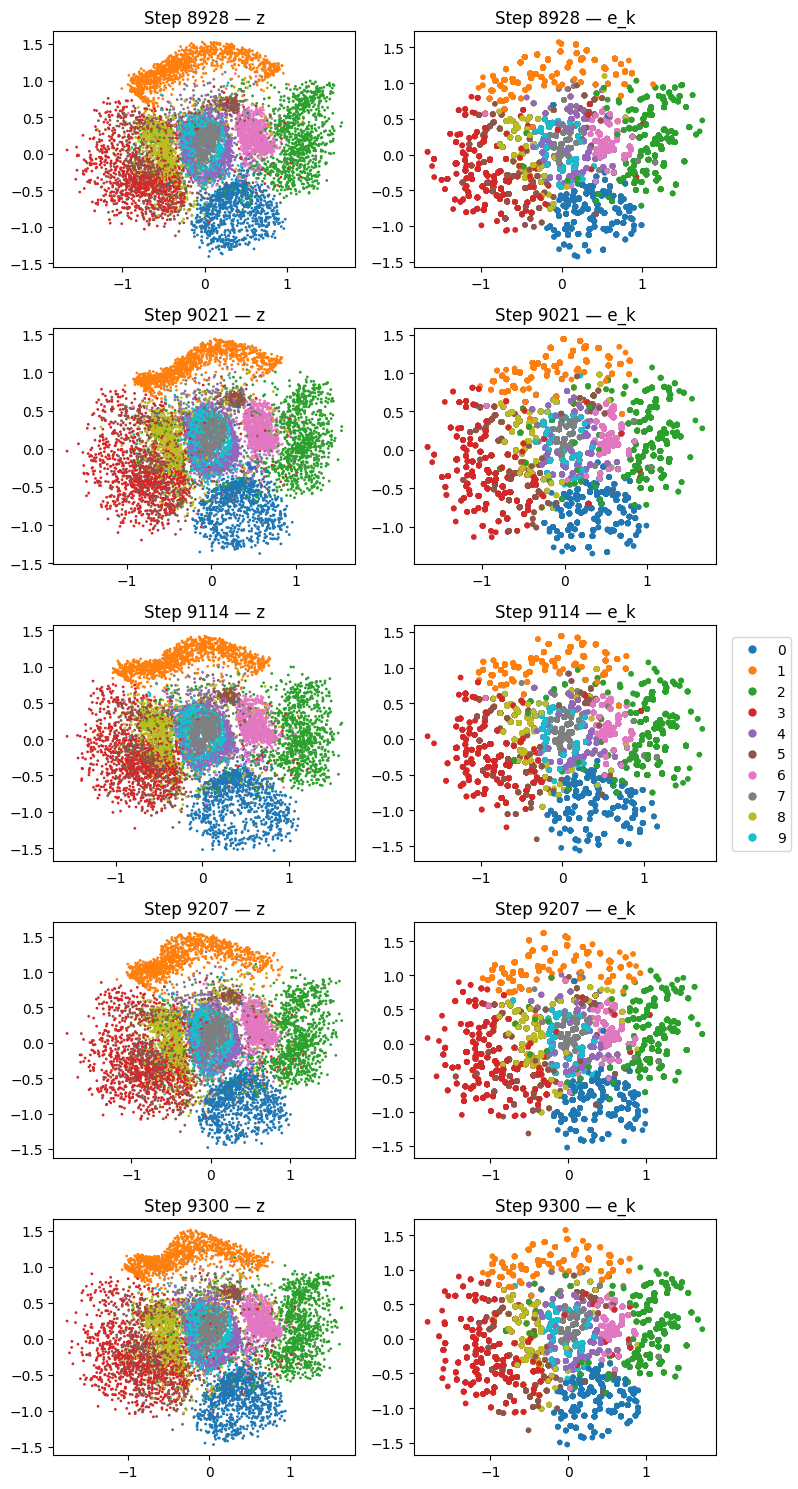

In [6]:
import umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

steps = list(latent.keys())[-5:]  # last 5 eval steps

fig, axes = plt.subplots(
    len(steps),
    2,
    figsize=(8, 3 * len(steps)),
    sharex=False,
    sharey=False,
)

for row, step in enumerate(steps):
    z, e_k, y = latent[step]      # z:[N,D], e_k:[N,D], y:[N]
    z = z.numpy()
    e_k = e_k.numpy()
    y = y.numpy()

    # both = np.concatenate([z, e_k], axis=0)   # [2N, D]
    # emb = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(both)
    z2  = z #emb[:len(z)]
    ek2 = e_k #emb[len(z):]

    axL = axes[row, 0]
    axR = axes[row, 1]

    axL.scatter(z2[:, 0],  z2[:, 1],  c=y, s=1, cmap="tab10", vmin=0, vmax=9)
    axR.scatter(ek2[:, 0], ek2[:, 1], c=y, s=10, cmap="tab10", vmin=0, vmax=9)

    axL.set_title(f"Step {step} — z")
    axR.set_title(f"Step {step} — e_k")

# legend once
handles = [
    Line2D([0], [0], marker="o", linestyle="", markerfacecolor=plt.cm.tab10(i),
           markeredgecolor="none", label=str(i))
    for i in range(10)
]
fig.legend(handles=handles, loc="center right")
plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()


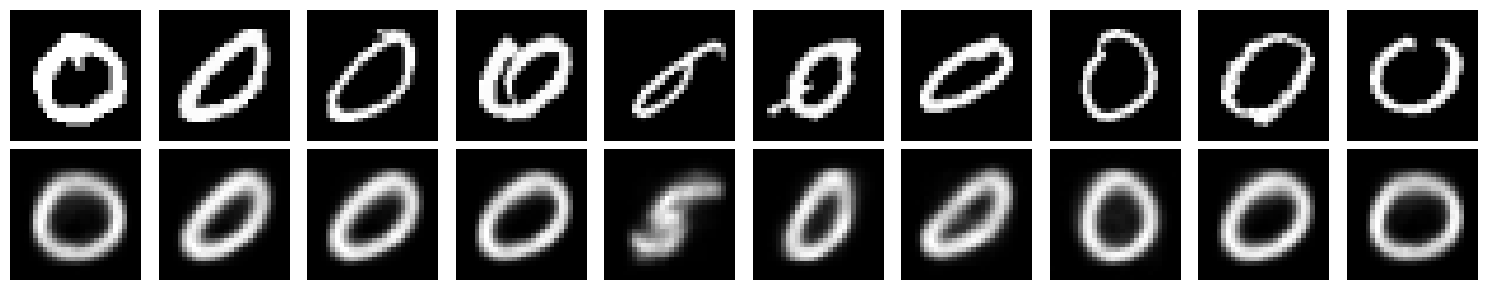

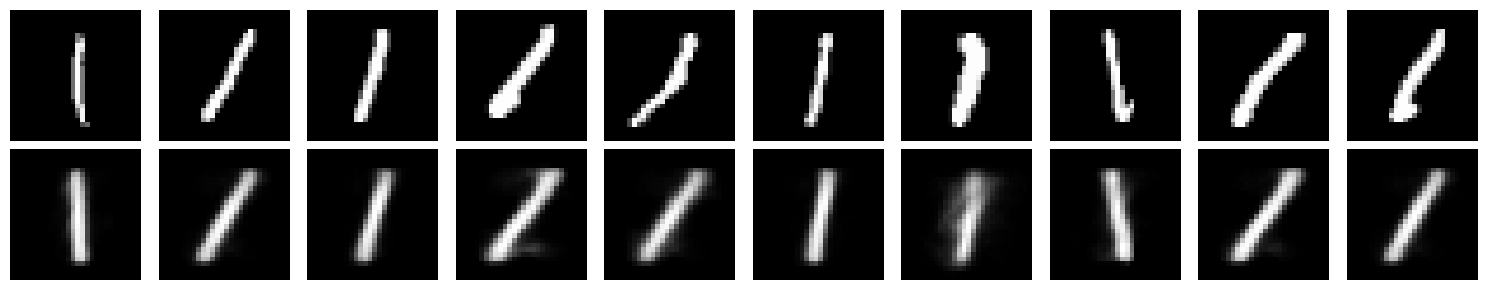

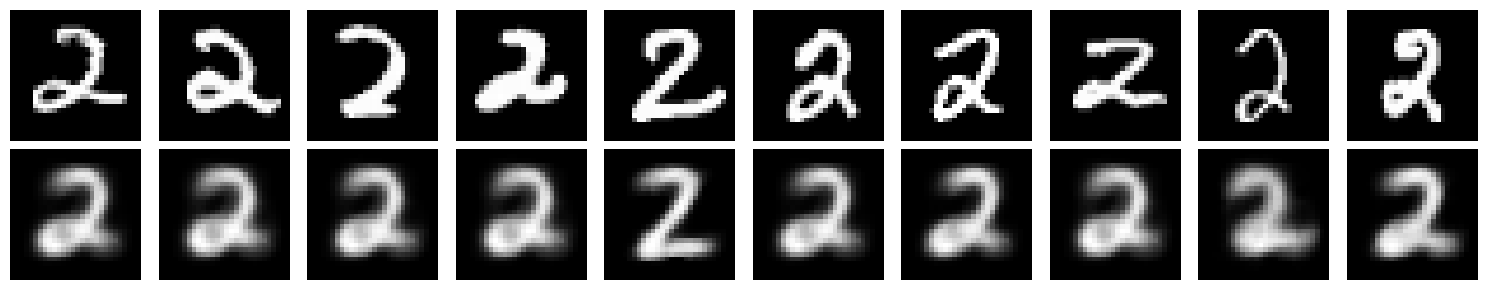

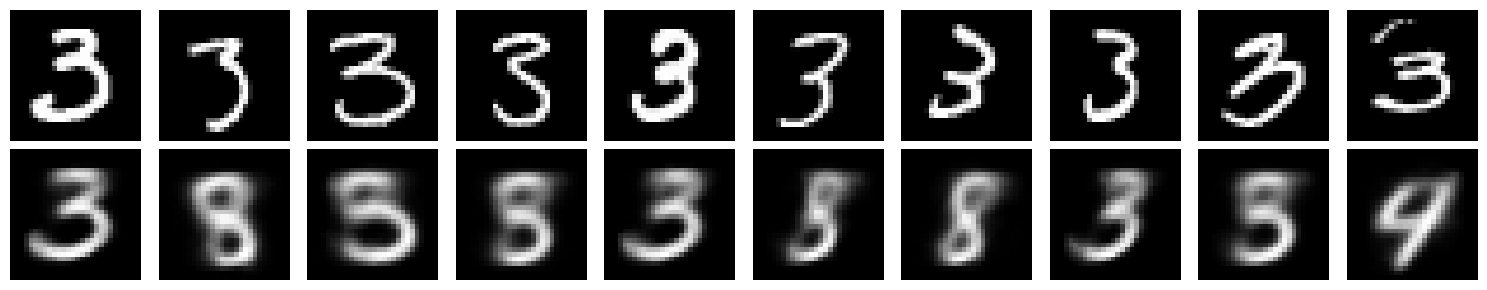

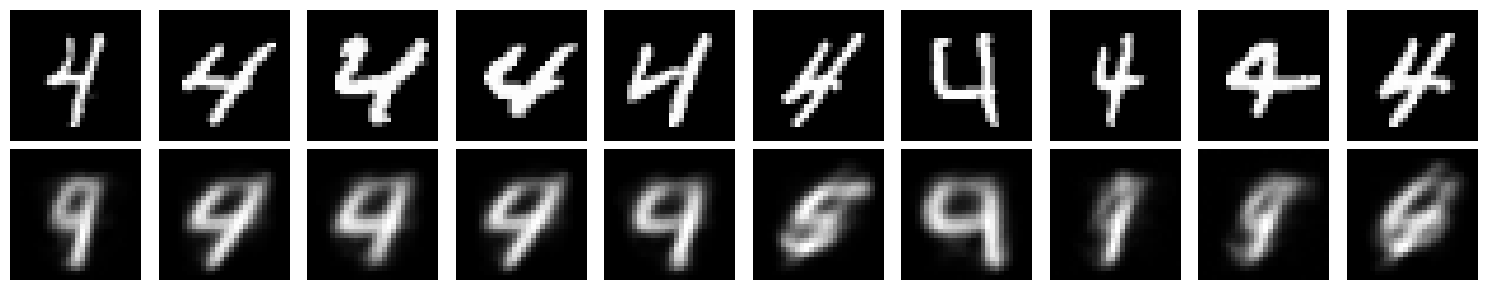

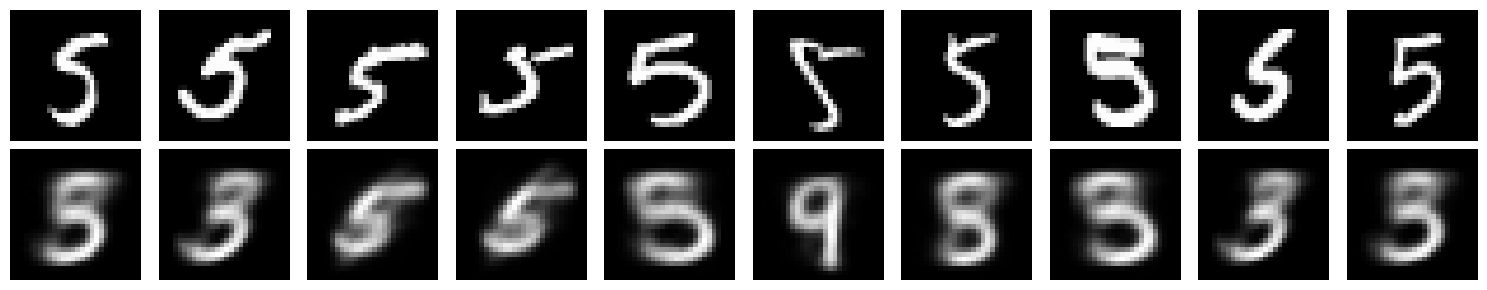

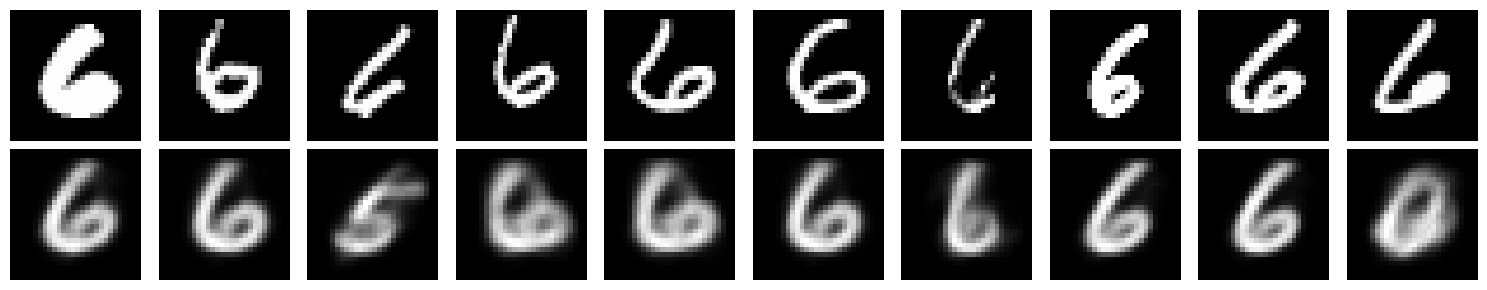

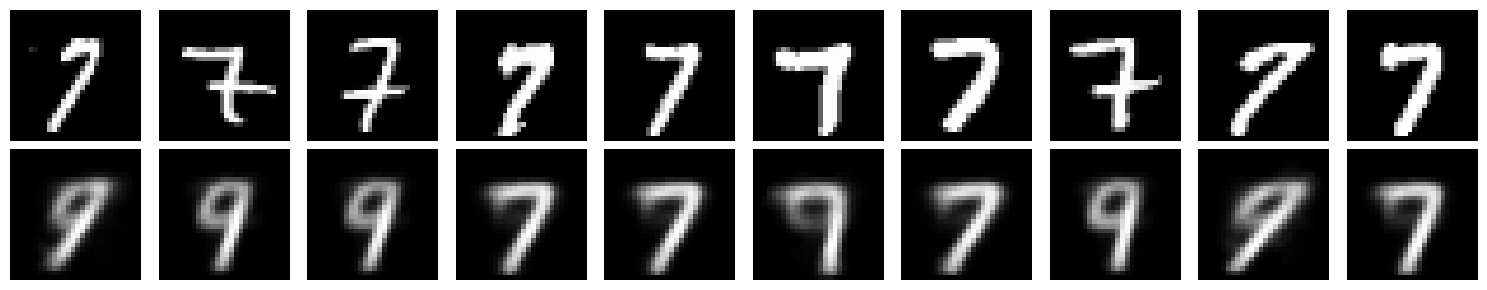

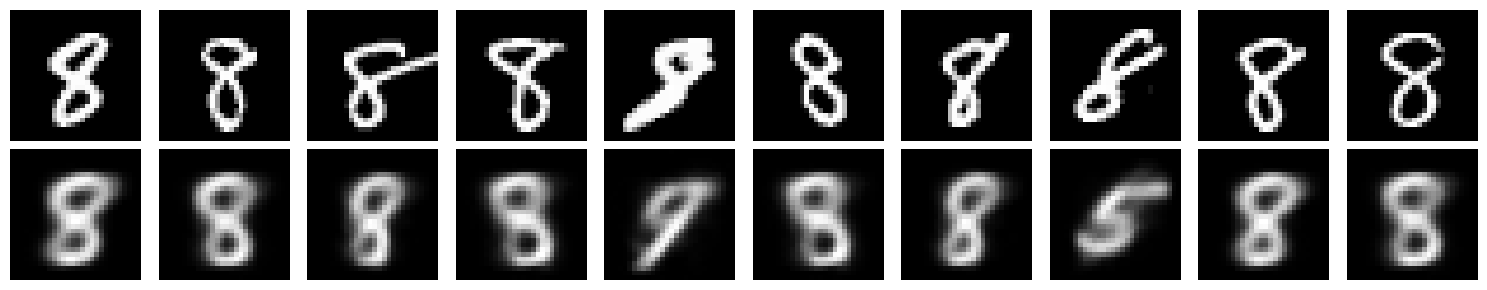

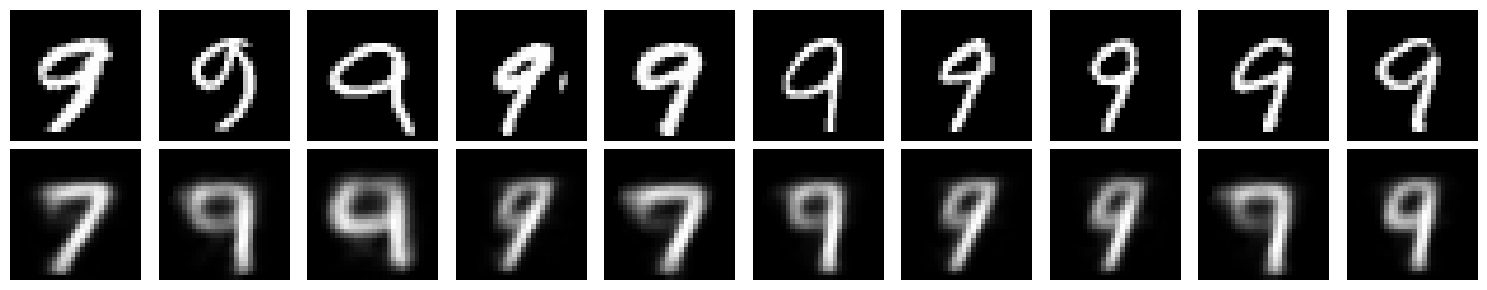

In [7]:
import random
import matplotlib.pyplot as plt

model.eval()

for digit in range(10):
    idxs = [i for i, (_, y) in enumerate(test_set) if y == digit]
    chosen = random.sample(idxs, 10)

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))

    for col, idx in enumerate(chosen):
        image, label = test_set[idx]

        with torch.no_grad():
            rec, _, _, _ = model(image.unsqueeze(0).to(device))

        image = image.view(28, 28)  # or (32,32)
        rec = rec.cpu().view(28, 28)

        # input (top row)
        axes[0, col].imshow(image, cmap="gray")
        axes[0, col].axis("off")

        # reconstruction (bottom row)
        axes[1, col].imshow(rec, cmap="gray")
        axes[1, col].axis("off")

    plt.tight_layout()
    plt.show()

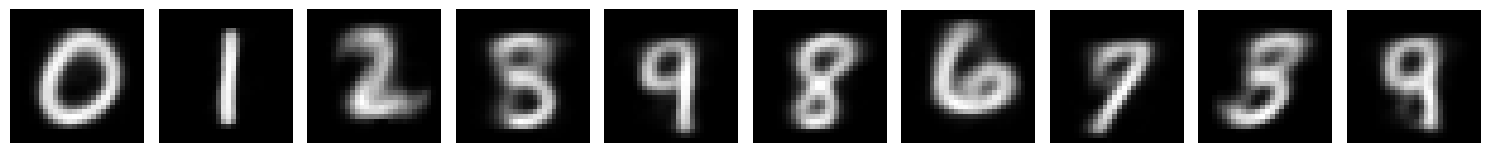

In [8]:
import torch
import matplotlib.pyplot as plt

last_step = list(latent.keys())[-1]
z, ek, y = latent[last_step]
z = z.cpu()
y = y.cpu()

proto = []
for digit in range(10):
    z_d = z[y == digit]  # [Nd, latent_dim]
    mu = torch.median(z_d, dim=0).values  # center
    std = z_d.std(dim=0).clamp_min(1e-3)  # scale

    eps = torch.randn_like(mu)
    proto.append(mu + 0.5 * std * eps)  # <-- randomness

proto = torch.stack(proto, dim=0)  # [10, latent_dim]

model.eval()
with torch.no_grad():
    pred = model.decode(proto.to(device)).cpu()

pred = pred.view(10, 1, 28, 28)

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for d in range(10):
    axes[d].imshow(pred[d, 0], cmap="gray")
    axes[d].axis("off")

plt.tight_layout()
plt.show()

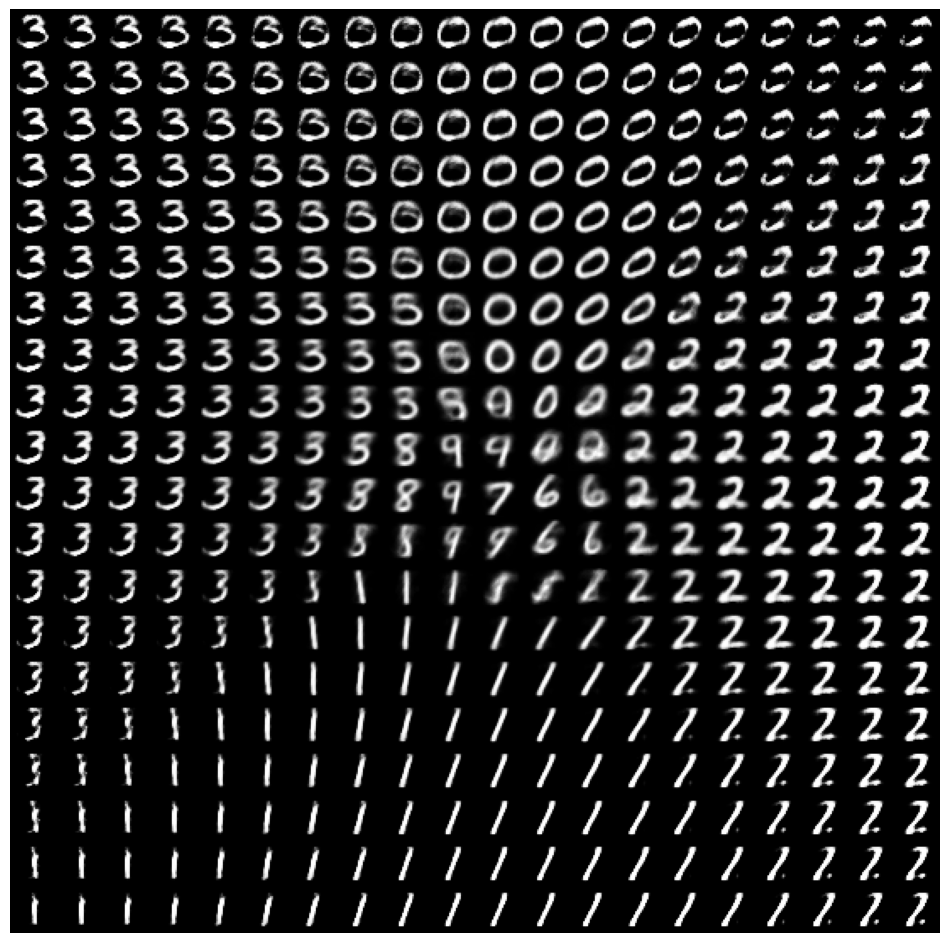

In [9]:
import matplotlib.pyplot as plt


def interpolate_space(
    model,
    x_range=(-3, 3),
    y_range=(-3, 3),
    num_steps=20,
    img_shape=(1, 28, 28),
    device="cuda",
):
    model.eval()

    # Build a num_steps x num_steps grid in latent space (no numpy)
    xs = torch.linspace(x_range[0], x_range[1], num_steps, device=device)
    ys = torch.linspace(y_range[0], y_range[1], num_steps, device=device)
    yy, xx = torch.meshgrid(ys, xs, indexing="ij")  # shapes: (num_steps, num_steps)
    points = torch.stack([xx, yy], dim=-1).reshape(-1, 2)  # shape: (num_steps^2, 2)

    with torch.no_grad():
        pred = model.decode(points)  # (num_steps^2, prod(img_shape))

    # Turn flat vectors into (C,H,W) images
    pred = pred.reshape(num_steps, num_steps, *img_shape).detach().cpu()

    fig, ax = plt.subplots(num_steps, num_steps, figsize=(12, 12))
    for i in range(num_steps):
        for j in range(num_steps):
            img = pred[i, j]
            if img.shape[0] == 1:
                ax[i, j].imshow(img[0], cmap="gray")
            else:
                ax[i, j].imshow(img.permute(1, 2, 0))  # still torch tensor
            ax[i, j].axis("off")

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()


interpolate_space(model)

If you take a close look at the latents, do you see that a lot of the generations are repeated? We no longer have variety in our generation... This is because we have mapped every encoding from our encoder neural network to a single Embedding vector. Again remember, the output of our encoder was a Batch Size x Latent Dim, and each latent dim was mapped to the single quantized embedding. What if we have multiple embedding vectors per image?

The output of our convolutional encoder is Batch x Latent Channel x Height x Width. Ignoring the batch size for now, we can reshape this image to Height*Width x Latent, and then each latent vector for every pixel in our image will get a quantized representation.

That means if our image was mapped to a 4 Latent Dim x 4 Height x 4 Width, this will be mapped to a 16 pixels x 4 latent dim, so all 16 pixels will be independently mapped to a latent dimension. If we have 512 unique codevectors in our image, then we will have a total of 512*16 possible combinations of latents to generate from!

# Audio

In [ ]:
import torch
import torchaudio
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from vqvae import VQVAE

torch.manual_seed(0)

def plot_codebook(pca, embeddings, step, plot_out):
    emb = embeddings.detach().cpu().numpy()
    K = emb.shape[0]

    if emb.shape[1] > 2:
        emb_2d = pca.transform(emb)
    else:
        emb_2d = emb[:, :2]

    with plot_out:
        plot_out.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(5,5))

        colors = plt.cm.tab10(np.linspace(0, 1, K))
        ax.scatter(emb_2d[:,0], emb_2d[:,1], s=120, c=colors, alpha=0.9, edgecolors="black")

        ax.set_title(f"Codebook step {step}")
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(-0.5, 0.5)
        ax.grid(True)

        plt.show()

filename = "M01UD01p10"
x, sr = torchaudio.load(f"data/audio/{filename}.wav")

from IPython.display import Audio
Audio(x.detach().squeeze().cpu().numpy(), rate=16000)

In [ ]:
# open question why the committment loss and code loss do not pull thez_e and codebook closer to each other
import os
import ipywidgets as widgets
from IPython.display import display
from sklearn.decomposition import PCA
import torchaudio

plot_out = widgets.Output()
display(plot_out)

T = x.shape[-1]
T_pad = ((T + 63) // 64) * 64
if T_pad != T:
    x = F.pad(x, (0, T_pad - T))  # [1, 1, T_pad]


device = "cuda" if torch.cuda.is_available() else "cpu"
x = x.unsqueeze(1).to(device)

model = VQVAE(hidden_dim=256, n_layers=6, codebook_size=100).to(device)
pca = PCA(n_components=2)
pca.fit(model.vq.codebook.weight.detach().cpu().numpy())

with torch.no_grad():
    y, z_e, ids = model(x)              # z_e: [B*T_e, D]
    K = model.vq.codebook.num_embeddings
    perm = torch.randperm(z_e.size(0), device=z_e.device)[:K]
    model.vq.codebook.weight.copy_(z_e[perm])

optimizer = optim.AdamW(model.parameters(), lr=0.0005)
for step in range(10000):
    optimizer.zero_grad()
    
    y, z_e, ids = model(x)
    e_k = model.vq.codebook(ids)  # [B*T_e, D]
    
    mse = F.mse_loss(y, x)
    codebook_loss = torch.mean((z_e.detach() - e_k) ** 2)
    commitment_loss = torch.mean((z_e - e_k.detach()) ** 2)
    
    loss = mse + codebook_loss + 0.25 * commitment_loss

    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(set(ids.tolist()))
        # print(model.vq.codebook.weight.pow(2).sum(-1))
        # print(z_e.detach().pow(2).sum(-1))
        print(f"step {step}: loss = {loss.item():.6f}")
        print(f"mse: {mse.item():.4f}, cb: {codebook_loss.item():.4f}, com: {commitment_loss.item():.4f}")
        y_audio = y[0, 0, :T].detach().float().cpu().clamp(-1, 1).unsqueeze(0)  # [1, T]
        torchaudio.save(os.path.join(f"recon_step_{step:05d}.wav"), y_audio, sr)

        # 🔥 plot codebook embeddings
        plot_codebook(pca, model.vq.codebook.weight, step, plot_out)

print(f"step {step+1}: loss = {loss.item():.6f}")

Output()

step 0: loss = 0.010433
mse: 0.0104, cb: 0.0000, com: 0.0000


step 1000: loss = 0.002026
mse: 0.0006, cb: 0.0012, com: 0.0012


step 2000: loss = 0.001529
mse: 0.0005, cb: 0.0009, com: 0.0009


step 3000: loss = 0.001294
mse: 0.0004, cb: 0.0007, com: 0.0007


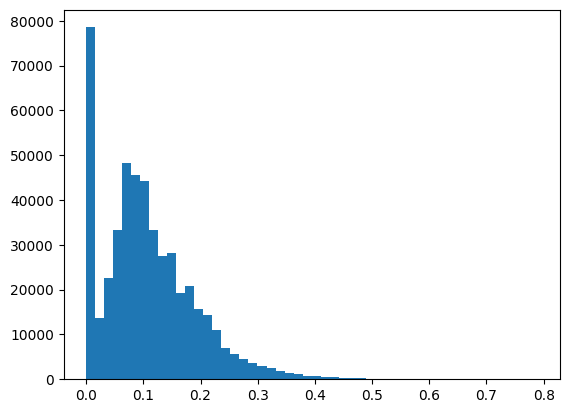

In [ ]:
import matplotlib.pyplot as plt

values = z_e.reshape(-1).detach().cpu().numpy()
plt.hist(values, bins=50)

In this notebook I explore how different architectural choices in a fully convolutional Vector-Quantised Variational Autoencoder (VQ-VAE) influence the quality of audio reconstruction.

Evaluating reconstruction quality remains the most direct and fundamental way to understand how well the model learns a latent representation. In the case of a VQ-VAE, however, the reconstruction loss is only one part of the full objective. Because the latent space is discrete, the encoder output must be mapped to the nearest embedding vector in a learned codebook. This introduces two additional terms—the codebook loss and the commitment loss—that encourage the embeddings to represent the encoder outputs faithfully and prevent the encoder from drifting too far from the discrete latent space.

$$
\mathcal{L} = 
\underbrace{\|x - \hat{x}\|_2^2}_{\text{reconstruction}} 
\;+\;
\underbrace{\|\mathrm{sg}[z_e] - e\|_2^2}_{\text{codebook loss}} 
\;+\;
\beta \,
\underbrace{\|z_e - \mathrm{sg}[e]\|_2^2}_{\text{commitment loss}}
$$


The central question is how reconstruction fidelity changes as I vary the main architectural parameters of the VQ-VAE. As in the earlier autoencoder experiment, I investigate two fundamental dimensions:

- **number of layers** (`n_layers`): determines the depth of the encoder and decoder, and thus the compression factor. More layers produce a more aggressive temporal downsampling and force the discrete latent space to model longer-range structure.
- **hidden dimension** (`hidden_dim`): the number of channels in every convolutional block. A larger hidden dimension increases the capacity of both the encoder and the decoder and typically improves quantisation quality by giving the encoder a richer continuous representation before quantisation.
- **number of codebook** entries (`num_codes` or $K$): the size of the discrete latent space. This determines how many distinct embedding vectors the encoder can choose from when mapping its continuous output to the discrete representation.

In [ ]:
from IPython.display import Audio

with torch.no_grad():
    y, _, _ = model(x.to(device))

Audio(y.detach().squeeze().cpu().numpy(), rate=16000)

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset import WavDataset
from vqvae import VQVAE
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = WavDataset("/home/lpozzi/Git/bitbybit/data/audio/chunks")
loader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

model = VQVAE(hidden_dim=512, n_layers=3, codebook_size=100).to(device)
# optimizer = optim.AdamW(model.parameters(), lr=1e-4)

decay, no_decay = [], []
for n, p in model.named_parameters():
    if "vq.codebook" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer = torch.optim.AdamW(
    [{"params": decay, "weight_decay": 1e-2},
     {"params": no_decay, "weight_decay": 0.0}],
    lr=1e-4,
)

num_epochs = 10
log_every = 2

model.eval()

with torch.no_grad():
    # get ONE batch
    x = next(iter(loader))
    x = x.to(device)  # [B, 1, T]

    # forward pass
    y, z_e, ids = model(x)  # z_e: [N, D]

    K = model.vq.codebook.num_embeddings
    N = z_e.size(0)

    assert N >= K, f"Not enough latents ({N}) to init {K} codes"

    # random subset of encoder outputs
    perm = torch.randperm(N, device=z_e.device)[:K]
    model.vq.codebook.weight.copy_(z_e[perm])

model.train()
global_step = 0

steps_per_epoch = len(loader)

print(f"Steps per epoch: {steps_per_epoch}")

for epoch in range(num_epochs):
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for x in loader:
        x = x.to(device)  # [B, 1, T]

        optimizer.zero_grad()

        y, z_e, ids = model(x)                 # y: [B,1,T], z_e: [N,D], ids: [N]
        e_k = model.vq.codebook(ids)           # [N, D]

        mse = F.mse_loss(y, x)
        codebook_loss = ((z_e.detach() - e_k) ** 2).mean()
        commitment_loss = ((z_e - e_k.detach()) ** 2).mean()

        loss = mse + codebook_loss + 0.25 * commitment_loss
        loss.backward()
        optimizer.step()

        if global_step % log_every == 0:
            print(
                f"epoch {epoch} step {global_step} | "
                f"loss {loss.item():.4f} (mse {mse.item():.4f} cb {codebook_loss.item():.4f} com {commitment_loss.item():.4f}) | "
                f"codes used {ids.unique().numel()}"
            )

        global_step += 1


Steps per epoch: 10


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

epoch 0 step 0 | loss 0.0273 (mse 0.0273 cb 0.0000 com 0.0000) | codes used 100
epoch 0 step 2 | loss 0.0187 (mse 0.0180 cb 0.0005 com 0.0005) | codes used 44
epoch 0 step 4 | loss 0.0147 (mse 0.0137 cb 0.0008 com 0.0008) | codes used 28
epoch 0 step 6 | loss 0.0134 (mse 0.0121 cb 0.0010 com 0.0010) | codes used 19
epoch 0 step 8 | loss 0.0097 (mse 0.0081 cb 0.0013 com 0.0013) | codes used 18


Epoch 1/10:   0%|          | 0/10 [00:05<?, ?it/s]


epoch 1 step 10 | loss 0.0084 (mse 0.0064 cb 0.0017 com 0.0017) | codes used 21
epoch 1 step 12 | loss 0.0069 (mse 0.0043 cb 0.0020 com 0.0020) | codes used 16
epoch 1 step 14 | loss 0.0095 (mse 0.0062 cb 0.0026 com 0.0026) | codes used 16
epoch 1 step 16 | loss 0.0100 (mse 0.0064 cb 0.0029 com 0.0029) | codes used 14
epoch 1 step 18 | loss 0.0106 (mse 0.0065 cb 0.0033 com 0.0033) | codes used 12


Epoch 2/10:   0%|          | 0/10 [00:04<?, ?it/s]


epoch 2 step 20 | loss 0.0101 (mse 0.0056 cb 0.0037 com 0.0037) | codes used 12
epoch 2 step 22 | loss 0.0102 (mse 0.0052 cb 0.0040 com 0.0040) | codes used 11
epoch 2 step 24 | loss 0.0112 (mse 0.0052 cb 0.0048 com 0.0048) | codes used 9


KeyboardInterrupt: 

In [ ]:
0.0143

In [ ]:
from IPython.display import Audio
model.eval()

x = dataset[0]        # [1, T]
x = x.unsqueeze(0)    # [B=1, 1, T]
x = x.to(device)
with torch.no_grad():
    y, _, _ = model(x.to(device))

Audio(y.detach().squeeze().cpu().numpy(), rate=24000)

In [ ]:
dataset = WavDataset("/home/lpozzi/Git/bitbybit/data/audio/chunks")
loader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)
xmin, xmax = 0, 0
for x in loader:
    if x.min() < xmin: xmin=x.min()
    if x.max() > xmax: xmax=x.max()
xmin, xmax

(tensor(-0.6098), tensor(0.7221))

In [ ]:
x.shape

torch.Size([16, 1, 48000])

In [ ]:
with torch.no_grad():
    hist = torch.bincount(ids, minlength=model.vq.codebook.num_embeddings).float()
    p = hist / hist.sum().clamp_min(1)
    perplexity = torch.exp(-(p * (p.clamp_min(1e-12)).log()).sum())

    top1 = p.max().item()
    ze_mean = z_e.mean().item()
    ze_std = z_e.std().item()
print(f"perp {perplexity.item():.1f} top1 {top1:.3f} z_e(mean,std)=({ze_mean:.3f},{ze_std:.3f})")


perp 3.2 top1 0.544 z_e(mean,std)=(0.011,0.025)


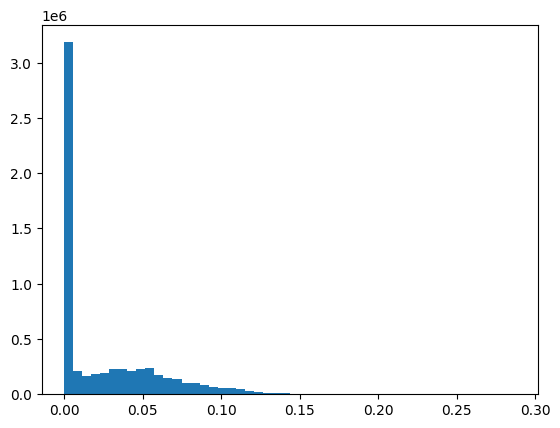

In [ ]:
import matplotlib.pyplot as plt

values = z_e.reshape(-1).detach().cpu().numpy()
plt.hist(values, bins=50);

In [ ]:
from datasets import load_dataset

ds = load_dataset("audiofolder", data_dir="/home/lpozzi/Git/bitbybit/data/audio")  # {"train": Dataset}

def collate_fn(batch):
    wavs = [torch.tensor(b["audio"]["array"]).float() for b in batch]
    lengths = torch.tensor([w.shape[-1] for w in wavs])          # [B]
    max_len = lengths.max()

    padded = []
    for w in wavs:
        pad = max_len - w.shape[-1]
        padded.append(F.pad(w.unsqueeze(0), (0, pad)))  # [1, max_len]

    x = torch.stack(padded, dim=0)      # [B, 1, max_len]
    return x, lengths

from torch.utils.data import DataLoader

trainloader = DataLoader(
    ds['train'],
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn,
)

In [ ]:
https://huggingface.co/datasets/MushanW/GLOBE